In [62]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [63]:
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_ssim

import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
#from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask

%load_ext autoreload
%autoreload 2
plt.ioff()
import scipy.misc

BATCH_SIZE = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
TRAIN_DIR = 'data/TRAIN_DIR/'
TEST_DIR = 'data/TEST_DIR/'
VAL_DIR = 'data/VAL_DIR/'

In [4]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory,class_mode=None, *args, **kwargs)
        #while True:
        for ori in generator:    
            #print("halo")
            # Get augmentend image samples
            #ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            

In [5]:
# Create training generator
train_datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(512, 512), batch_size=BATCH_SIZE
)

In [6]:
# Create validation generator
val_datagen = DataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(512, 512), batch_size=BATCH_SIZE, seed=1
)

In [7]:
# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(512, 512),batch_size=BATCH_SIZE, seed=1
)# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data
from collections import defaultdict
scores = defaultdict(list)
def evaluate_real_losses(ori,masked,mask):
    mse_scores,ssim_scores = zip(*[masked_area_score(o,m,mm) for o,m,mm in zip(ori,masked,mask)])
    mse_score = np.mean(mse_scores)
    ssim_score = np.mean(ssim_scores)
    scores['masked_area'].append({'MSE':mse_score,'SSIM':ssim_score})
    mse_scores,ssim_scores = zip(*[outside_area_score(o,m,mm) for o,m,mm in zip(ori,masked,mask)])
    mse_score = np.mean(mse_scores)
    ssim_score = np.mean(ssim_scores)
    scores['outside_area'].append({'MSE':mse_score,'SSIM':ssim_score})
    mse_scores,ssim_scores = zip(*[whole_image_score(o,m,mm) for o,m,mm in zip(ori,masked,mask)])
    mse_score = np.mean(mse_scores)
    ssim_score = np.mean(ssim_scores)
    scores['whole_image'].append({'MSE':mse_score,'SSIM':ssim_score})

Found 200 images belonging to 2 classes.


In [8]:
def masked_area_score(img_true,img_predict,mask):
    mse =mean_squared_error(img_true[mask==0], img_predict[mask==0])
    ssim =compare_ssim(img_true[mask==0], img_predict[mask==0]) 
    return mse, ssim
def whole_image_score(img_true,img_predict,mask):
    mse =mean_squared_error(img_true[mask!=5], img_predict[mask!=5])
    ssim =compare_ssim(img_true[mask!=5], img_predict[mask!=5]) 
    return mse, ssim
def outside_area_score(img_true,img_predict,mask):
    mse =mean_squared_error(img_true[mask==1], img_predict[mask==1])
    ssim =compare_ssim(img_true[mask==1], img_predict[mask==1]) 
    return mse, ssim

In [10]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    evaluate_real_losses(ori,pred_img,mask)
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'logs/img_{}_{}.png'.format(i, pred_time))
        plt.close()

In [11]:
#####################################################
####### TRAIN PHASE 1   #############################

In [12]:
# Instantiate the model
model = PConvUnet(weight_filepath='logs/')
# model.load('logs/700_weights_2019-01-23-15-20-38.h5')

In [13]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=16,
    validation_data=val_generator,
    validation_steps=10,
    epochs=100,        
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir='../logs/initial_training', write_graph=False),
        #Lol()
    ]
)

Epoch 1/1
Found 287 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
16/16 [==============================] - 16s 1s/step - loss: 1945519.2031 - val_loss: 1869487.1125
Epoch 2/2
16/16 [==============================] - 12s 723ms/step - loss: 1655815.1406 - val_loss: 1759090.0250
Epoch 3/3
16/16 [==============================] - 12s 734ms/step - loss: 1684645.8203 - val_loss: 1655244.6750
Epoch 4/4
16/16 [==============================] - 12s 762ms/step - loss: 1630234.2656 - val_loss: 1689729.6923
Epoch 5/5
16/16 [==============================] - 12s 731ms/step - loss: 1599635.6797 - val_loss: 1491111.8250
Epoch 6/6
16/16 [==============================] - 12s 753ms/step - loss: 1553713.5625 - val_loss: 1517335.5500
Epoch 7/7
16/16 [==============================] - 12s 754ms/step - loss: 1471107.5234 - val_loss: 1481873.2750
Epoch 8/8
16/16 [==============================] - 12s 771ms/step - loss: 1366361.4023 - val_loss: 1357221.4750
Epoch 9/9
16/16 [=======

In [24]:
scores

defaultdict(list,
            {'masked_area': [{'mse': 0.012181739, 'ssim': 0.9188576307635311},
              {'mse': 0.007105197, 'ssim': 0.9214896802157732},
              {'mse': 0.009625433, 'ssim': 0.9314030958685922},
              {'mse': 0.0054246215, 'ssim': 0.9244680919230828},
              {'mse': 0.011315696, 'ssim': 0.9281564644334547},
              {'mse': 0.005656409, 'ssim': 0.9142550035193215},
              {'mse': 0.00828988, 'ssim': 0.9183088720108908},
              {'mse': 0.0085805915, 'ssim': 0.9123001197538553}],
             'outside_area': [{'mse': 0.0011826335,
               'ssim': 0.9058703783718298},
              {'mse': 0.00058412325, 'ssim': 0.8690551858126048},
              {'mse': 0.000575842, 'ssim': 0.9219075819987452},
              {'mse': 0.00068977685, 'ssim': 0.8847522218898314},
              {'mse': 0.0022063805, 'ssim': 0.9199247503545617},
              {'mse': 0.0009436506, 'ssim': 0.8000534217297808},
              {'mse': 0.0007097

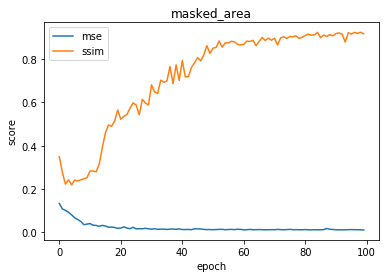

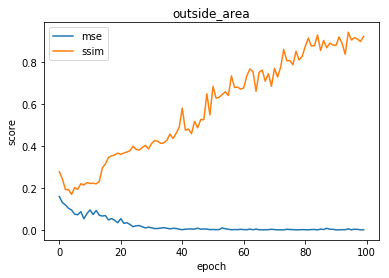

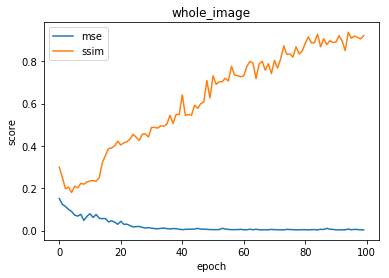

In [14]:
for key,value in scores.items():
    ax=pd.DataFrame(value).plot(title=key)
    ax.set_xlabel('Number of epochs')
    ax.set_ylabel('Evaluation score')

In [15]:
#plot_callback(model)

In [16]:
#cores

In [ ]:
################  predict, evaluate ##########################
#############################################################

In [17]:
model = PConvUnet(weight_filepath='logs/')
model.load('logs/100_weights_2019-01-27-16-40-47.h5')

In [28]:
lesion_list = np.load('data/lesion_slice100_512x512_3.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


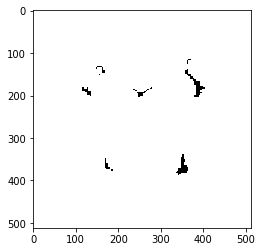

In [86]:
plt.imshow(lesion_list[0]*255)

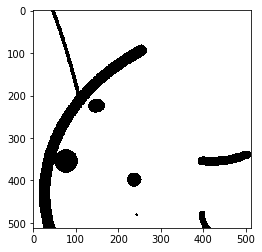

In [85]:
a= random_mask(512,512,channels=3)
plt.imshow(a*255)

In [75]:
np.max(a)

1

In [66]:
np.shape(random_mask(512,512))

(512, 512, 3)

In [39]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory,class_mode=None, *args, **kwargs)
        #while True:
        for ori in generator:    
            #print("halo")
            # Get augmentend image samples
            #ori = next(generator)

            # Get masks for each image sample
            #mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            mask = np.stack([lesion_list[i] for i in range(ori.shape[0])], axis = 0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            

In [40]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    evaluate_real_losses(ori,pred_img,mask)
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'img_results/img_{}_{}.png'.format(i, pred_time))
        plt.close()

In [41]:
scores = defaultdict(list)

In [42]:
# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(512, 512),batch_size=BATCH_SIZE, seed=1)# Pick out an example
mask_list = []
masked_list=[]
ori_list = []
for _ in range(8):
    (masked, mask), ori = next(test_generator)
    plot_callback(model)

Found 200 images belonging to 2 classes.


In [43]:
scores

defaultdict(list,
            {'masked_area': [{'MSE': 0.4490772, 'SSIM': 0.17127969079536753},
              {'MSE': 0.34326404, 'SSIM': 0.2506070124410418},
              {'MSE': 0.41821373, 'SSIM': 0.1644971532776903},
              {'MSE': 0.36420768, 'SSIM': 0.2907752171236906},
              {'MSE': 0.55170214, 'SSIM': 0.14741691326268738},
              {'MSE': 0.2011281, 'SSIM': 0.37645184320748565},
              {'MSE': 0.38026625, 'SSIM': 0.25194896105295295},
              {'MSE': 0.4022233, 'SSIM': 0.2061225022882739}],
             'outside_area': [{'MSE': 0.007185823, 'SSIM': 0.9571245275642654},
              {'MSE': 0.0022109046, 'SSIM': 0.9455086065050441},
              {'MSE': 0.0047426177, 'SSIM': 0.960028560060816},
              {'MSE': 0.0015930783, 'SSIM': 0.9353771110758186},
              {'MSE': 0.008927483, 'SSIM': 0.962250765602207},
              {'MSE': 0.00092731544, 'SSIM': 0.9010248940838985},
              {'MSE': 0.003957855, 'SSIM': 0.9550436785997